[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/howesa/CHI22-CogMod-Tutorial/blob/main/04-Modelbuilding/04_Go_Nogo.ipynb)


In [ ]:
# Install the files to local.
# Please note that the go / no go model we are using here is still being developed,
# and should not yet be adapted for other work! The development is in close collaboration
# with the Commotions project at Leeds, led by Gustav Markkula, and collaborated with Aravinda Srinivasan.
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/animate_trace.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/driver_agent_physics.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/go_nogo.py
! wget https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/physics_env.py

In [ ]:
# Install the required libraries.
! pip install --pre -U stable_baselines3
! pip install gym
! pip install shimmy

# Module 4: Building a Model

In this module, we take a step-by-step walktrough of how to create a computational rational (CR) model using deep reinforcement learning (RL). This notebook does not cover the full workflow of CR modeling, which is long and detailed. It can be found here, make sure to follow it when creating your own models. For the purpose of this notebook, the simplified workflow looks like this:

1. Define the goals.

2. Define the environment.

3. Define the cognitive limitations.

4. Derive the optimal behavior.

5. Inspect model validity.

The model will be defined according to the standard CR flow of information.

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/corati_model.png" alt="Corati Modeling" width="700">


# 1. Define the agent's goals

The task explored in this notebook is a fairly simple one: in a junction, when turning against the oncoming traffic, the driver needs to decide if they can go, or if they need to wait for an oncoming car before they can cross. In left-handed traffic, this means that the agent driver is turning right. Here is the illustration:

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/04-Go_Nogo/go_nogo_task.png" alt="Go / No go task" width="300">

The agent (the yellow car) has two main goals:

1. **Proceed** to the destination by turning left.

2. Drive **safely**, avoiding collisions.

First, we need to analyze these goals. First, the agent wants to drive efficiently and not get stuck on the road for too long. They probably want to get to their destination, and also they would be blocking the traffic behind them if they wait unreasonably long. So we can analyse these goals into a reward function.

1. When the agent **turns left successfully**, there is a positive reward.
2. For this positive reward, there is a penalty of **time spent** waiting.
3. For a **collision**, there is a negative reward.

**Task 1**. Discuss alternative goals that the driver may have. Can you specify them in terms of the scalar reward function?

# 2. Define the task environment

For simplicity, the environment has only two cars, in a 2-dimensional environment: the agent's car and the oncoming car. The cars are particles that have their individual `(x,y)` coordinates. The agent's car is stationary until the agent decides to turn left. The oncoming car has a variable position, which moves along the y-axis of the environment according to its velocity, which is fixed constant. A collision is detected if the vehicles are too close to each other regardless of their velocities.

In [1]:
# Let's define an environment and an agent and see how it works.
import physics_env
import driver_agent_physics

e = physics_env.physics_env()
agent = driver_agent_physics.driver_agent_physics(e, observation_var = 0) # a full observer: no noise
agent.reset()

{'distance': [0.09501283128730656],
 'speed': [0.298],
 'acceleration': [0],
 'passed': [0],
 'distance_var': [0],
 'ticks': [0.0]}

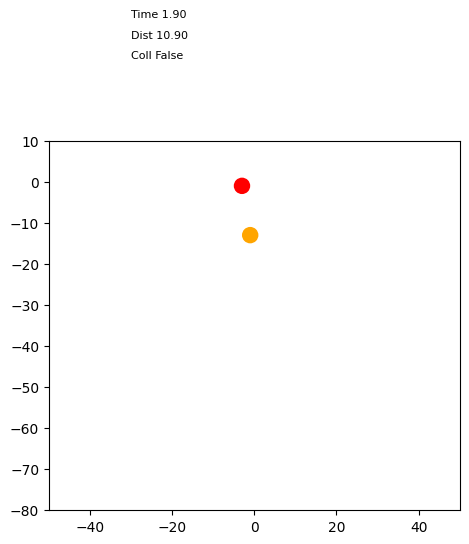

In [2]:
# Let's wait for 20 ticks, then go.
from IPython.display import HTML, display
import animate_trace

agent.reset(y_start = -30)
agent.env.save_trace = True
for i in range(20):
    agent.step(0)
agent.step(1)
agent.env.save_trace = False

HTML(animate_trace.animate_trace(agent.env.trace, get_anim = True, x_lim = [-50,50], y_lim = [10,-80]).to_jshtml())

**Task 2.** Change the starting distance of the incoming car. Try to collide the cars! (Note that the y-coordinate needs to be negative.)

# 3. Define the relevant cognitive bounds of the agent

The agent must make a decision to go (turn left) or wait. It bases this decision on a noisy observation of the oncoming car's distance to the agent's car. If the distance is long enough, the agent can go and save time. If the car is too close, the agent must wait for it to pass to avoid a collision.

For modeling noisy observation, we will be using the formula from Markkula, et al. (2022). Explaining human interactions on the road requires large-scale integration of psychological theory. https://psyarxiv.com/hdxbs/

$ \hat{D} = D_{oth} \cdot \left(1 - \frac{h}{D \cdot \tan \left(\arctan \left(\frac{h}{D}\right) + \sigma \right)}\right) $,

where $ \hat{D} $ is a noisy observation of distance, $D_{oth}$ is the oncoming car's longitudinal distance to the crossing point, and $h$ is the observer's eye height over ground (1.5m). The important parameter here is $\sigma$, which describes how noisy the observation is.

The noisy observation is not used directly, but via Bayesian filtering. This considers prior belief about the distance and integrates the new observation with it. Additionally, we represent the uncertainty associated with the belief.

Before deriving the optimal behavior, we want to establish what hypotheses our model in fact makes, so that we can then assess the plausibility of model predictions against them. While modeling is virtually always interactive and the hypotheses might develop during iteration, but it is important to have a strong initial assumption about how our model will behave. Here are initial proposals, which would then be turned into exact, testable hypotheses:

P1. For a non-noisy (full) observer, there is a precise distance: if the other car is farther than this distance, the agent decides to go. If the other car is closer, the agent chooses to wait. If the car has passed, the agent always goes.

P2. For a noisy (partial) observer, the decision to go is more conservative and uncertain: the distance that determines the go / no go decision is larger, and due to noisy estimates, the choice is probabilistic given distance.

/tmp/ipykernel_6053/3488772976.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


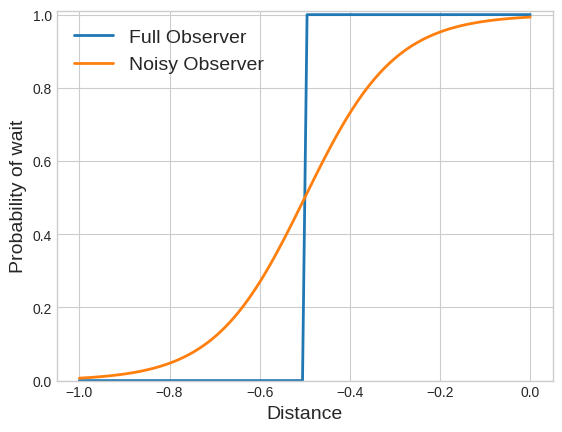

In [12]:
# Here is a theoretical illustration of our proposals.
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
x1 = np.linspace(-1, 0, 100)
x2 = np.linspace(-1, 0, 100)
y1 = np.zeros(100)
y1[50:] = 1
y2 = 1 / (1 + np.exp(-10*(x2+0.5)))
plt.plot(x1, y1, label='Full Observer', linewidth = 2)
plt.plot(x2, y2, label='Noisy Observer', linewidth = 2)
plt.ylim(0, 1.01)
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Probability of wait', fontsize=14)
plt.legend(fontsize=14)
plt.show()

**Task 3.** Discuss what the hypothesis actually means. What do the lines tell us?

## How does the noisy observation happen?

The observation of the approaching vehicle distance is noisy. In practice, we simulate noisy observation by taking the true observation and then adding noise from a normal distribution, according to some parameter sigma. However, instead of using the returned noisy value as such, we assume that the human visual system exploits the fact that each noisy value is based on the true value, and the noise comes from a known distribution. We can then use a Kalman filter to approximate the true state. With more observations, the approximation becomes better. In our simulation, this is confounded by the formula above, which states that observations get better as the distance shortens. Let's investigate this behavior.

In [14]:
import math
import numpy as np

# Here is the formula for making an observation, given distance.
def noisy_observation(D):
    # D = distance in meters
    d_oth = D+2 # crossing point distance, this is a crude approximation to simplify our exercise
    h = 1.5 # eye height
    observation_var = 0.1 # this is the sigma
    distance_var = d_oth * (1 - h / (D*math.tan(math.atan(h/D) + observation_var)))
    observed_distance = np.random.normal(D, distance_var)
    return observed_distance, distance_var


# Let's see what kinds of observations we make from the true distance of 50 m
for i in range(10):
    print(noisy_observation(50)[0])

-37.61008471235189
63.70481602817908
48.31110483805534
28.38442432645445
33.33467965935759
53.392496267653094
22.730345799313636
23.38515471955667
90.9017528733917
11.040384635738278


In [15]:
# So, that's not a very reliable observation! Here is the Kalman filter, let's see how it helps.
def kalman_update(prior_mean, prior_var, observation, s):
        observation_gain = 1
        kalman_gain = prior_var * observation_gain / (prior_var * observation_gain**2 + s**2)
        posterior_mean = prior_mean + kalman_gain * (observation - prior_mean)
        posterior_var = (1 - kalman_gain * observation_gain) * prior_var

        return posterior_mean, posterior_var
    
# Then, let's update both mean and variance estimates multiple times
distance_prior = 100 # set an uninformed prior
distance_var_prior = 1000 # basically a uniform prior
for i in range(20):
    d, s = noisy_observation(50)
    distance_post, distance_var_post = kalman_update(distance_prior, distance_var_prior, d, s)
    # Store result
    print(distance_post)
    # Set the posterior as the new prior
    distance_prior = distance_post
    distance_var_prior = distance_var_post

94.97497687985411
77.34482435409713
77.35418035840522
84.66891318462982
63.37687705416661
57.890286378839086
58.22863523098924
54.25393440227137
54.84339482164586
59.42921165063366
51.96607479678724
49.218412200826194
50.57178585542257
53.68878804676445
51.77929086551476
48.106096853759055
47.52772275126394
48.17032499010157
47.06153309872953
47.34785753048278


/tmp/ipykernel_6053/3240931969.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


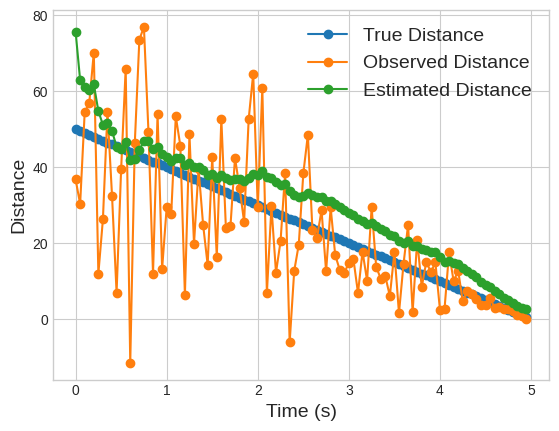

In [16]:
# Can we visualize it? Let's assume a constant velocity of 0.5 m per observational "tick".
# Assuming one tick is 0.05s, this is 10m/s = 36km/h
import matplotlib.pyplot as plt

true_d = 50
distance_prior = 100 # set an uninformed prior
distance_var_prior = 1000 # basically a uniform prior
velocity = 0.5
data = []
for i in range(100):
    d, s = noisy_observation(true_d)
    distance_post, distance_var_post = kalman_update(distance_prior, distance_var_prior, d, s)
    # Store result
    data.append([true_d, d, distance_post])
    # Set the posterior as the new prior
    distance_prior = distance_post
    distance_var_prior = distance_var_post
    # "Move" the approaching vehicle
    true_d -= velocity
    
# Make the plot
true_distance, observed_distance, estimated_distance = zip(*data)
index = np.array(range(len(data))) / 20 # make into seconds
plt.style.use('seaborn-whitegrid')
plt.plot(index, true_distance, label='True Distance', linestyle='-', marker='o')
plt.plot(index, observed_distance, label='Observed Distance', linestyle='-', marker='o')
plt.plot(index, estimated_distance, label='Estimated Distance', linestyle='-', marker='o')

plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Distance', fontsize = 14)
plt.legend(loc='best', fontsize = 14)

plt.show()

In [17]:
import numpy as np

import math

def h_func(D):
    h = 1.5
    d_oth = D + 2
    return d_oth * (1 - h / (D * math.tan(math.atan(h / D))))

def h_jacobian(D):
    h = 1.5
    d_oth = D + 2
    dh_dD = -(h * d_oth) / (D**2 * math.tan(math.atan(h / D)) + D * h)
    return np.array([[dh_dD]])


def ekf_update(prior_mean, prior_var, observation, s, h_func, h_jacobian):
    # Define the nonlinear observation function h(x) and its Jacobian H.
    # These functions should be defined outside the update function.
    
    # Linearize the observation function using the Jacobian.
    H = h_jacobian(prior_mean)
    
    # Calculate the Kalman gain.
    kalman_gain = prior_var * H.T / (H * prior_var * H.T + s**2)
    
    # Update the mean using the difference between the observation and the expected observation (h(x)).
    innovation = observation - h_func(prior_mean)
    posterior_mean = prior_mean + kalman_gain * innovation
    
    # Update the covariance.
    posterior_var = (1 - kalman_gain * H) * prior_var

    return posterior_mean, posterior_var

distance_prior = 100
distance_var_prior = 1000

for i in range(20):
    d, s = noisy_observation(50)
    
    # Use the ekf_update function instead of the kalman_update function
    distance_post, distance_var_post = ekf_update(distance_prior, distance_var_prior, d, s, h_func, h_jacobian)
    
    distance_post = distance_post[0][0]
    distance_var_post = distance_var_post[0][0]
    
    # Show result
    print(distance_post, distance_var_post)
    
    # Set the posterior as the new prior
    distance_prior = distance_post
    distance_var_prior = distance_var_post


88.69720105665436 860.5699676073118
57.22484959909111 754.8014004823099
48.687362939209194 670.3956049017435
49.829768032032455 602.2490408192247
44.248759953807294 546.7697159591787
30.331936611456147 500.2380158125028
18.354433412384203 459.56067893307994
13.950020307491503 422.3851329909508
7.916549750063807 388.9399357448766
-3.6838156439758754 355.18365371270716
-8.389261163211005 351.1259622962101
-12.215018504665803 340.33179565770337
-16.03514157940583 328.16828369303784
-20.288439742685647 315.80391594136876
-23.293962327710812 303.6688116722895
-26.05265309545037 292.124598376103
-27.9334382112976 281.220084161226
-27.724603424749432 270.9908716118038
-28.3456288297989 261.4903633389229
-34.74971496027888 252.60426505494974


/tmp/ipykernel_6053/4259345192.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


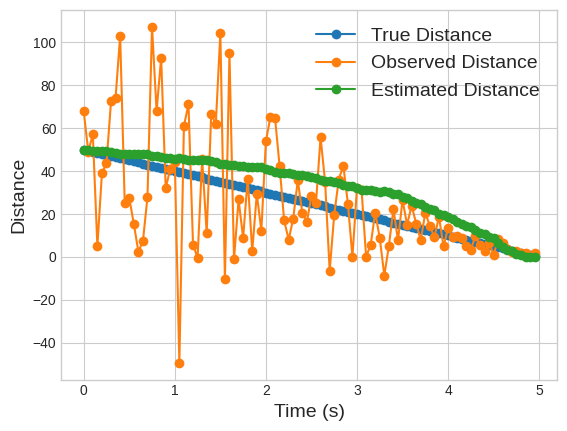

In [18]:
import matplotlib.pyplot as plt

true_d = 50
distance_prior = 50 # set an uninformed prior
distance_var_prior = 10 # basically a uniform prior
velocity = 0.5
data = []
for i in range(100):
    d, s = noisy_observation(true_d)
    distance_post, distance_var_post = ekf_update(distance_prior, distance_var_prior, d, s, h_func, h_jacobian)    
    distance_post = distance_post[0][0]
    distance_var_post = distance_var_post[0][0]
    # Store result
    data.append([true_d, d, distance_post])
    # Set the posterior as the new prior
    distance_prior = distance_post
    distance_var_prior = distance_var_post
    # "Move" the approaching vehicle
    true_d -= velocity
    
# Make the plot
true_distance, observed_distance, estimated_distance = zip(*data)
index = np.array(range(len(data))) / 20 # make into seconds
plt.style.use('seaborn-whitegrid')
plt.plot(index, true_distance, label='True Distance', linestyle='-', marker='o')
plt.plot(index, observed_distance, label='Observed Distance', linestyle='-', marker='o')
plt.plot(index, estimated_distance, label='Estimated Distance', linestyle='-', marker='o')

plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Distance', fontsize = 14)
plt.legend(loc='best', fontsize = 14)

plt.show()

0 [2.00211823 0.04999047]
1 [3.01124509 0.14994702]
2 [4.03216036 0.29982946]
3 [5.06962147 0.49958039]
4 [6.12835716 0.74912361]
5 [7.21306047 1.04836198]
6 [8.32838119 1.39717508]
7 [9.47891749 1.79541631]
8 [10.66920686  2.2429097 ]
9 [11.90371605  2.73944626]
10 [13.18683003  3.28477994]
11 [14.52283995  3.87862314]
12 [15.91592984  4.52064181]
13 [17.37016213  5.21045019]
14 [18.88946189  5.94760504]
15 [20.47759962  6.73159962]
16 [22.13817278  7.56185722]
17 [23.87458581  8.4377244 ]
18 [25.69002878  9.35846391]
19 [27.58745459 10.32324748]
20 [29.56955493 11.3311483 ]
21 [31.63873486 12.38113351]
22 [33.79708636 13.47205665]
23 [36.04636081 14.6026502 ]
24 [38.38794076 15.77151828]
25 [40.82281115 16.97712976]
26 [43.35153027 18.21781178]
27 [45.97420089 19.49174387]
28 [48.69044187 20.79695289]
29 [51.49936075 22.13130889]
30 [54.39952783 23.49252206]
31 [57.3889522  24.87814108]
32 [60.46506044 26.28555281]
33 [63.62467846 27.71198373]
34 [66.86401721 29.15450321]
35 [70.1786

/tmp/ipykernel_6053/1792566695.py:67: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


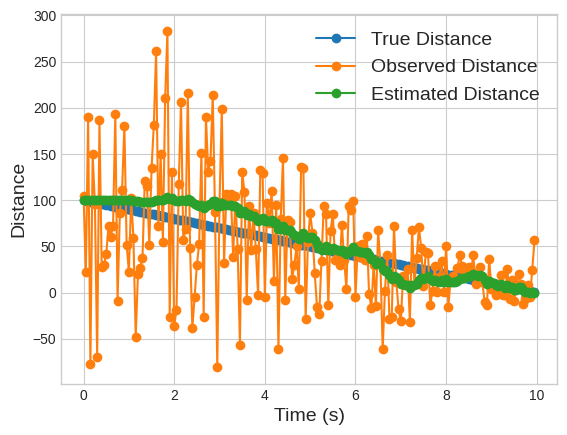

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Here is the formula for making an observation, given distance.
def noisy_observation(D):
    # D = distance in meters
    d_oth = D+2 # crossing point distance, this is a crude approximation to simplify our exercise
    h = 1.5 # eye height
    observation_var = 5 # this is the sigma
    distance_var = d_oth * (1 - h / (D*math.tan(math.atan(h/D) + observation_var)))
    observed_distance = np.random.normal(D, distance_var)
    return observed_distance, distance_var

def kalman_predict(state_mean, state_cov, transition_matrix, process_noise_cov):
    predicted_mean = np.dot(transition_matrix, state_mean)
    predicted_cov = np.dot(transition_matrix, np.dot(state_cov, transition_matrix.T)) + process_noise_cov
    return predicted_mean, predicted_cov

def kalman_update(state_mean, state_cov, observation, observation_cov, observation_matrix):
    innovation = observation - np.dot(observation_matrix, state_mean)
    innovation_cov = np.dot(observation_matrix, np.dot(state_cov, observation_matrix.T)) + observation_cov
    kalman_gain = np.dot(state_cov, np.dot(observation_matrix.T, np.linalg.inv(innovation_cov)))
    updated_mean = state_mean + np.dot(kalman_gain, innovation)
    updated_cov = state_cov - np.dot(kalman_gain, np.dot(observation_matrix, state_cov))
    return updated_mean, updated_cov

velocity = 0.5

# Initialize state vector (distance and velocity)
state_mean = np.array([[100], [velocity]])  # Initial distance and velocity
state_cov = np.array([[1, 0], [0, 1]])  # Initial covariance matrix

# Define the transition matrix for the constant velocity model
dt = 0.05  # Time step (in seconds)
transition_matrix = np.array([[1, dt], [0, 1]])

# Define the process noise covariance matrix
process_noise_cov = np.array([[1, 0], [0, 1]])

# Define the observation matrix
observation_matrix = np.array([[1, 0]])
data = []
true_d = 100
for i in range(200):
    d, s = noisy_observation(true_d)
    
    # Perform the state prediction step
    state_mean, state_cov = kalman_predict(state_mean, state_cov, transition_matrix, process_noise_cov)
    
    # Perform the state update step
    state_mean, state_cov = kalman_update(state_mean, state_cov, d, s**2, observation_matrix)
    
    # Show result (distance)
    #print(state_mean[0][0])

    # Velocity
    print(i, state_cov[0])

    data.append([true_d, d, state_mean[0][0]])
    
    true_d -= velocity
    
# Make the plot
true_distance, observed_distance, estimated_distance = zip(*data)
index = np.array(range(len(data))) / 20 # make into seconds
plt.style.use('seaborn-whitegrid')
plt.plot(index, true_distance, label='True Distance', linestyle='-', marker='o')
plt.plot(index, observed_distance, label='Observed Distance', linestyle='-', marker='o')
plt.plot(index, estimated_distance, label='Estimated Distance', linestyle='-', marker='o')

plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Distance', fontsize = 14)
plt.legend(loc='best', fontsize = 14)

plt.show()

**Task 3.5** Change the prior (distance and variance) and investigate how that changes the convergence of the posterior over time. You can also try changing the velocity and starting distance.

# 4. Derive optimal policy

For establishing the (bounded) optimal policy for the ideal and noisy observer agents, we will be using Proximal Policy Optimization, which is an on-policy deep RL algorithm. This notebook uses the OpenAI Stable Baselines implementation, but there are others as well. https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

Before we can derive the optimal policy, the environments (both internal and external) need to be modeled using Markov Decision Process (**MDP**, or in our case, due to partial observability, we are defining a **POMDP**). We won't go into the details of how the external driving environment is modeled, but it is a simple stepwise simulator, that for each time step (0.05 seconds by default), "ticks" the environment forward by moving the upcoming car's y-position according to its velocity, and in case the agent decides to go, moves it towards the side road along a predefined trajectory, in a constant velocity as well.

For the internal environment, we need to model the belief update for distance of the oncoming car, given the equation and filtering that were defined above. All relevant information must be represented as the agent's belief such that we can pass that, along with the reward signal, to the RL agent for learning the optimal policy.

In [3]:
# Here are the action and observation spaces of the agent

from gym.spaces import Discrete, Dict, Box

action_space = Discrete(2)        

# Note that all observatons are normalized between 0 and 1.
observation_space = Dict(
    spaces = {
        "distance": Box(0, 1, (1,)),
        "passed": Box(0, 1, (1,)),
        "distance_var": Box(0, 1, (1,)),
        "speed": Box(0, 1, (1,)),
        "acceleration": Box(0, 1, (1,)),
        "ticks": Box(0, 1, (1,))
    })

# Sample the action space:
print("A small sample of actions:", action_space.sample(), action_space.sample(), action_space.sample())
print("One sample of observation space:", observation_space.sample())

A small sample of actions: 0 1 0
One sample of observation space: OrderedDict([('acceleration', array([0.7039935], dtype=float32)), ('distance', array([0.47577325], dtype=float32)), ('distance_var', array([0.6372569], dtype=float32)), ('passed', array([0.0449013], dtype=float32)), ('speed', array([0.62759805], dtype=float32)), ('ticks', array([0.49574688], dtype=float32))])


So, the environment simulation works as intended. Let's now take a look at the reward function. Remember our definition:

1. When the agent **turns left successfully**, there is a positive reward.
2. For this positive reward, there is a penalty of **time spent** waiting.
3. For a **collision**, there is a negative reward.

We will establish the reward function along with one step of the model to see what actually happens when we step.

In [ ]:
def step(self, action):
    self.reward = 0
    # action: no go
    if action == 0:
        self.env.tick()
        self.ticks += 1
        # break if nothing ever happens
        if self.ticks > self.max_ticks:
            self.reward = -10
            self.done = True
        if self.env.get_distance() > self.max_distance:
            self.reward = -10
            self.done = True                
    # action: go
    if action == 1:
        # Did we wait for the other car before going?
        if self.env.veh2_turn_pos[1] < self.env.veh1_straight_pos[1]:
            self.waited_before_go = True
        self.distance_at_go = self.env.get_distance()
        self.done = True
        self.collision, _ = self.env.simulate_go()
        if self.collision:
            self.reward = -10
        else:
            self.reward = 10 - self.penalty_per_tick * self.ticks

    self.belief = self.get_belief()

    return self.belief, self.reward, self.done, {}

In [4]:
# Let's make and train the full observer agent.
import go_nogo
full_obs_agent = go_nogo.make_agent(sigma = 0, iters = 10)
# In the output:
# i = training iteration
# t = number of ticks (1 tick = 0.05s)
# r = average reward (10 is max)
# d = average distance of the two vehicles at the time of go (in meters)
# w = frequency of waits (agent waited the other car to pass before going)
# c = frequency of collisions


i	t	r	d	w	c
0	1.51	-0.22	16.54	0.0	0.51
1	1.57	-0.03	16.09	0.0	0.5
2	3.07	2.26	16.77	0.07	0.38
3	5.36	4.59	15.58	0.22	0.25
4	10.38	7.47	14.03	0.44	0.08
5	11.76	8.72	13.49	0.52	0.01
6	11.3	8.57	14.51	0.46	0.02
7	9.76	8.72	14.36	0.47	0.02
8	10.65	8.44	14.62	0.43	0.03
9	10.32	8.27	14.25	0.45	0.04


In [ ]:
# To keep training the agent without initializing it anew, use
go_nogo.retrain_agent(full_obs_agent, iters = 10)

In [ ]:
# Let's investigate if it has found a policy for the different distances.
# Keep an eye on the "critical" y_start at around -13.
HTML(go_nogo.animate_agent(full_obs_agent, y_start = -13.8, get_anim = True).to_jshtml())

In [5]:
# Train the noisy observer
noisy_obs_agent = go_nogo.make_agent(sigma = 0.1, iters = 10)


i	t	r	d	w	c
0	1.67	-0.03	16.47	0.0	0.5
1	1.53	2.17	17.39	0.0	0.39
2	1.96	0.56	16.17	0.0	0.47
3	2.6	0.53	15.47	0.0	0.47
4	3.12	2.28	16.04	0.05	0.38
5	5.2	3.47	15.77	0.18	0.31
6	8.52	6.49	15.14	0.34	0.14
7	9.85	6.32	13.82	0.42	0.14
8	15.41	7.16	11.9	0.6	0.07
9	10.49	7.86	13.96	0.45	0.06


In [ ]:
# To keep training the agent without initializing it anew, use
go_nogo.retrain_agent(noisy_obs_agent, iters = 10)

In [ ]:
# Let's investigate if it has found a policy for the different distances.
# Keep an eye on the "critical" y_start at around -13.
HTML(go_nogo.animate_agent(noisy_obs_agent, y_start = -13.8, get_anim = True).to_jshtml())

**Task 4.** Try to find out the critical distance where the two models, full and partial/noisy observer, differ in their go/no go policy.

# 5. Inspect model validity

After having converged the model to an optimal policy, our aim is to utilize it for generating simulations of task behavior. The evaluation of the model's validity encompasses multiple stages, see the workflow.pdf draft for these. Here, we concentrate solely on its face validity, which addresses whether the model aligns with our initial predictions.

Starting the model's validity assessment with face validity tests is a useful practice, as any discrepancies between the model's performance and our hypotheses at this stage may indicate issues with either the model's specification or our modeling assumptions. This is frequently an iterative procedure, during which we may observe the model's divergence from our expectations, resulting in identifying inadequate definitions of objectives, task environment, or cognitive constraints.

Once the model successfully demonstrates face validity, it should be subjected to a rigorous validation process, wherein its predictions are compared against human data or some alternative benchmarks. The model should e.g., generate accurate summary statistics (across a broader human population), be capable of replicating individual performance by adjusting specific parameters, and operate reasonably under changes in the environment. The specific validation depends always on the details of the modeling work.

In [9]:
# Run an experiment for obtaining multiple samples from each agent.
def wait_or_go_experiment(agent, y_range, n = 100, deterministic = False):
    data = []
    agent.env.veh1_straight_start_y_range = y_range
    for i in range(n):
        _, _, _, w, c = agent.run_episode(deterministic = deterministic)
        data.append([agent.observation_var, agent.env.y_start, w, c])
    
    agent.env.veh1_straight_start_y_range = [-25,-2] # return back to original
    return data

import pandas as pd

# Increase n to e.g., 2000 to get more robust final image, but note that it takes longer to run.
data = wait_or_go_experiment(full_obs_agent, y_range = [-5,-25], n = 1000, deterministic = True)
data = data + wait_or_go_experiment(noisy_obs_agent, y_range = [-5,-25], n = 200, deterministic = True)
columns = ['sigma', 'y_start', 'wait', 'collision']
df = pd.DataFrame(data, columns=columns)

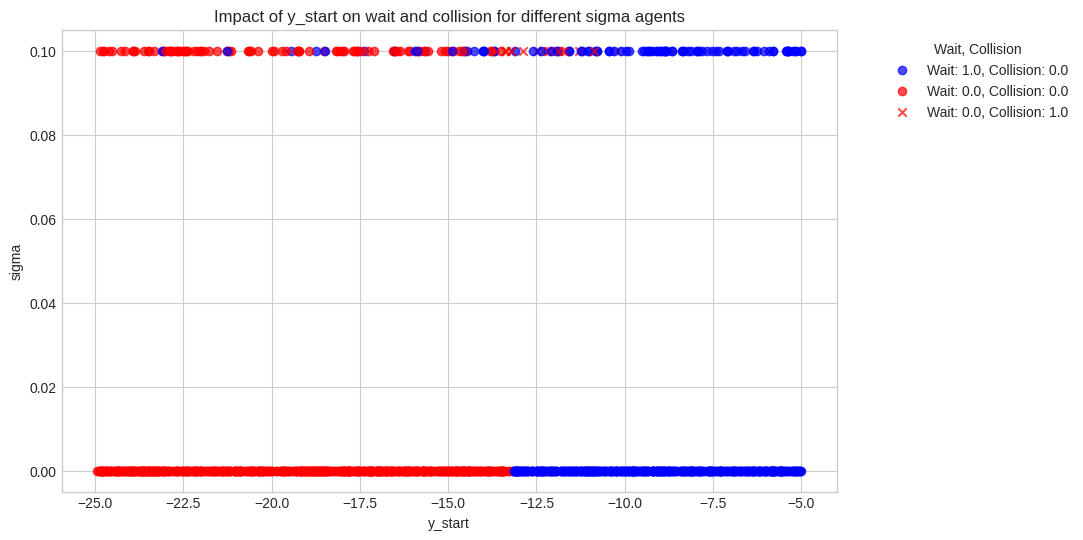

In [11]:
# Visualize individual go/no go decisions between different sigma models for various y_ranges.

import numpy as np
import matplotlib.pyplot as plt

# Note: this is a bit slow and dirty, gets slow with a lot of data. Only use for diagnosis.
def plot_data(df):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define custom colors and markers based on wait and collision values
    colors = {0: 'red', 1: 'blue'}
    markers = {0: 'o', 1: 'x'}

    # Create a dictionary to store the labels we've already added to the legend
    labels_added = {}

    for index, row in df.iterrows():
        sigma = row['sigma']
        y_start = row['y_start']
        wait = row['wait']
        collision = row['collision']
        label = f'Wait: {wait}, Collision: {collision}'

        # Add scatter plot point with custom color and marker
        ax.scatter(
            y_start,
            sigma,
            marker=markers[collision],
            color=colors[wait],
            label=label if label not in labels_added else "",
            alpha=0.7
        )
        
        # Remember that we've added this label to the legend
        labels_added[label] = True

    ax.set_xlabel('y_start')
    ax.set_ylabel('sigma')
    ax.legend(title="Wait, Collision", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Impact of y_start on wait and collision for different sigma agents')
    plt.show()
    
plot_data(df)

**Task 5.** Discuss the figure. What are we seeing here? What is the difference between the two models and how is it connected to the original hypotheses made?

/tmp/ipykernel_6053/3742620078.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


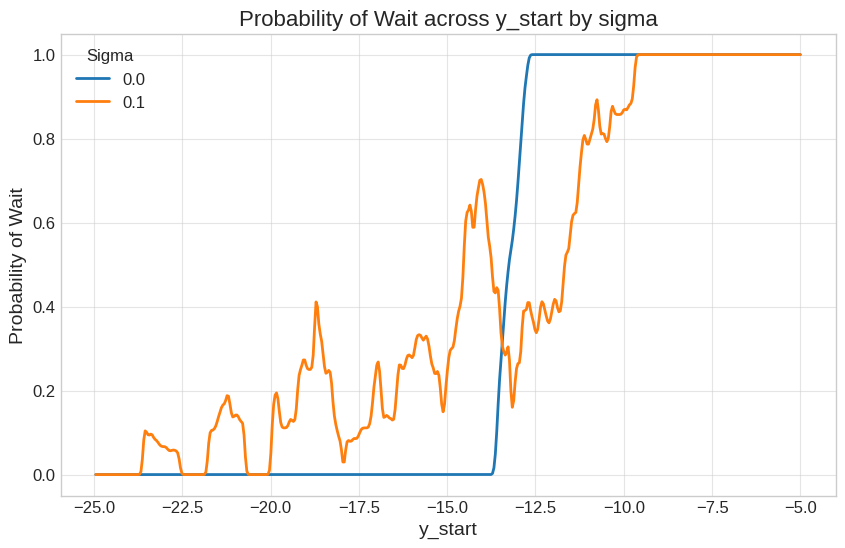

In [10]:
# Visualize the probability of go/no go as the function of y_start, between different sigmas.

# Change smoothness to larger to get less raggedy lines.
# Also, increase the N in the experiment above to get more observations.
smoothness = 1

from scipy.ndimage import gaussian_filter1d

def estimate_probability(df, sigma, y_start_values, window_size=1, collision = False):
    sub_df = df[df['sigma'] == sigma].sort_values('y_start')
    probabilities = []

    for y_start in y_start_values:
        window_df = sub_df[(sub_df['y_start'] >= y_start - window_size / 2) & (sub_df['y_start'] <= y_start + window_size / 2)]
        probability = window_df['collision' if collision else 'wait'].sum() / len(window_df)
        probabilities.append(probability)

    return probabilities

def smooth_probabilities(probabilities, sigma=1):
    return gaussian_filter1d(probabilities, sigma=sigma)

def plot_probability_lines(df, collision = False):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    y_start_range = np.linspace(df['y_start'].min(), df['y_start'].max(), num=500)

    for sigma in df['sigma'].unique():
        probabilities = estimate_probability(df, sigma, y_start_range, collision = collision)
        smoothed_probabilities = smooth_probabilities(probabilities, sigma = smoothness)
        ax.plot(y_start_range, smoothed_probabilities, label=f'{sigma}', linewidth=2)

    ax.set_xlabel('y_start', fontsize=14)
    ax.set_ylabel('Probability of Wait', fontsize=14)
    ax.legend(title="Sigma", loc="upper left", fontsize=12, title_fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Probability of Wait across y_start by sigma', fontsize=16)
    plt.grid(alpha=0.5)
    plt.show()

plot_probability_lines(df)